# Setting up

## load modules

In [ ]:
# %%capture
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os
import sys
import numpy as np
import xarray as xr
from dask.distributed import Client, LocalCluster
from tqdm import tqdm
import matplotlib.pyplot as plt 
from scipy.signal import periodogram, find_peaks, correlate, correlation_lags
import re
import warnings
from os import listdir
from pathlib import Path
import cv2
import dask as da
import math
import dask.array as darr
import xarray as xr
import zarr as zr
from natsort import natsorted
from tifffile import TiffFile, imread
import matplotlib
import shutil
from collections import defaultdict
from scipy.stats import zscore
from scipy.signal import savgol_filter
import math 




## set path and parameters

In [2]:
# Set up Initial Basic Parameters#
dpath = "/scratch/09117/xz6783/minian/Satiation/Session Combined/1H6"
# dpath = "/scratch/09656/dhh3/gdrive_duy_miniscope_local/Satiation/Session Combined/1H6"
dpath = os.path.abspath(dpath)
framesPerFile = 1000

# Pre-processing Parameters#
param_load_videos = {
    "start": 17,
    "end": 17,
    "pattern": "[0-9]+\.avi$", 
    "dtype": np.uint8,
    "downsample": dict(frame=1, height=1, width=1),
    "downsample_strategy": "subset",
}

os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["NUMBA_NUM_THREADS"] = "1"

## functions for loading in all videos

In [3]:
def load_videos(
    vpath,
    start=None,
    end=None,
    pattern=None,
    dtype=np.float64,
    in_memory=False,
    downsample=None,
    downsample_strategy="subset",
    post_process=None,
):
    if pattern is None:
        if start is not None and end is not None:
            pattern = r"[0-9]+\.avi$".format(start, end)
        else:
            pattern = r"[0-9]+\.avi$"

    """
    Load videos from the folder specified in `vpath` and according to the regex
    `pattern`, then concatenate them together across time and return a
    `xarray.DataArray` representation of the concatenated videos. The default
    assumption is video filenames start with ``msCam`` followed by at least a
    number, and then followed by ``.avi``. In addition, it is assumed that the
    name of the folder correspond to a recording session identifier.

    Parameters
    ----------
    vpath : str
        The path to search for videos
    pattern : str, optional
        The pattern that describes filenames of videos. (Default value =
        'msCam[0-9]+\.avi')

    Returns
    -------
    xarray.DataArray or None
        The labeled 3-d array representation of the videos with dimensions:
        ``frame``, ``height`` and ``width``. Returns ``None`` if no data was
        found in the specified folder.
    """
    vpath = os.path.normpath(vpath)
    ssname = os.path.basename(vpath)
    vlist = natsorted(
        [vpath + os.sep + v for v in os.listdir(vpath) if re.search(pattern, v)]
    )
    # Filter vlist based on the specified range
    if "start" in param_load_videos and param_load_videos["start"] is not None:
        start_frame = param_load_videos["start"]
    else:
        start_frame = 0

    if "end" in param_load_videos and param_load_videos["end"] is not None:
        end_frame = param_load_videos["end"]
    else:
        end_frame = float('inf')  # A placeholder for infinity to include all frames till the end

    vlist = [v for v in vlist if start_frame <= int(re.search(r'(\d+)', os.path.basename(v)).group(1)) <= end_frame]


    if not vlist:
        raise FileNotFoundError(
            "No data with pattern {}"
            " found in the specified folder {}".format(pattern, vpath)
        )
    print("loading {} videos in folder {}".format(len(vlist), vpath))

    file_extension = os.path.splitext(vlist[0])[1]
    if file_extension in (".avi", ".mkv"):
        movie_load_func = load_avi_lazy
    elif file_extension == ".tif":
        movie_load_func = load_tif_lazy
    else:
        raise ValueError("Extension not supported.")

    varr_list = [movie_load_func(v) for v in vlist]
    varr = darr.concatenate(varr_list, axis=0)
    varr = xr.DataArray(
        varr,
        dims=["frame", "height", "width"],
        coords=dict(
            frame=np.arange(varr.shape[0]),
            height=np.arange(varr.shape[1]),
            width=np.arange(varr.shape[2]),
        ),
    )
    if dtype:
        varr = varr.astype(dtype)
    if downsample:
        bin_eg = {d: np.arange(0, varr.sizes[d], w) for d, w in downsample.items()}
        if downsample_strategy == "mean":
            varr = (
                varr.coarsen(**downsample, boundary="trim")
                .mean()
                .assign_coords(**bin_eg)
            )
        elif downsample_strategy == "subset":
            varr = varr.sel(**bin_eg)
        else:
            warnings.warn("unrecognized downsampling strategy", RuntimeWarning)
    varr = varr.rename("fluorescence")
    if post_process:
        varr = post_process(varr, vpath, ssname, vlist, varr_list)
    return varr

def load_tif_lazy(fname):
    data = TiffFile(fname)
    f = len(data.pages)

    fmread = da.delayed(load_tif_perframe)
    flist = [fmread(fname, i) for i in range(f)]

    sample = flist[0].compute()
    arr = [
        da.array.from_delayed(fm, dtype=sample.dtype, shape=sample.shape)
        for fm in flist
    ]
    return da.array.stack(arr, axis=0)


def load_tif_perframe(fname, fid):
    return imread(fname, key=fid)


def load_avi_lazy(fname):
    cap = cv2.VideoCapture(fname)
    f = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    fmread = da.delayed(load_avi_perframe)
    flist = [fmread(fname, i) for i in range(f)]
    sample = flist[0].compute()
    arr = [
        da.array.from_delayed(fm, dtype=sample.dtype, shape=sample.shape)
        for fm in flist
    ]
    return da.array.stack(arr, axis=0)


def load_avi_perframe(fname, fid):
    cap = cv2.VideoCapture(fname)
    h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    cap.set(cv2.CAP_PROP_POS_FRAMES, fid)
    ret, fm = cap.read()
    if ret:
        return cv2.cvtColor(fm, cv2.COLOR_RGB2GRAY)
    else:
        print("frame read failed for frame {}".format(fid))
        return np.zeros((h, w))


## start cluster

In [4]:
cluster = LocalCluster(n_workers=30, memory_limit="5GB")
client = Client(cluster)

# Misalignment detection

## loading videos and visualization

In [5]:
param_load_videos

{'start': 17,
 'end': 17,
 'pattern': '[0-9]+\\.avi$',
 'dtype': numpy.uint8,
 'downsample': {'frame': 1, 'height': 1, 'width': 1},
 'downsample_strategy': 'subset'}

In [6]:
%%time
varr = load_videos(dpath, **param_load_videos)

loading 1 videos in folder /scratch/09117/xz6783/minian/Satiation/Session Combined/1H6
CPU times: user 381 ms, sys: 51.4 ms, total: 432 ms
Wall time: 1.67 s


In [7]:
varr_ref = varr.chunk({"frame": 20, "height": -1, "width": -1})

In [8]:
varr_ref

<xarray.DataArray 'fluorescence' (frame: 1000, height: 600, width: 600)>
dask.array<rechunk-merge, shape=(1000, 600, 600), dtype=uint8, chunksize=(20, 600, 600), chunktype=numpy.ndarray>
Coordinates:
  * frame    (frame) int64 0 1 2 3 4 5 6 7 8 ... 992 993 994 995 996 997 998 999
  * height   (height) int64 0 1 2 3 4 5 6 7 ... 592 593 594 595 596 597 598 599
  * width    (width) int64 0 1 2 3 4 5 6 7 8 ... 592 593 594 595 596 597 598 599

## get rid of V4 stripe noise (present on earlier releases of the V4 scope)

In [9]:
# f = 0
# im = varr_ref[f,:,:].copy().values
# im_fft = fftpack.fft2(im.astype(np.float64))
# im_fft2 = im_fft.copy()
# n = 5
# y = 2
# im_fft2[n:im_fft2.shape[0]-n, :y] = 0
# im_fft2[n:im_fft2.shape[0]-n, -y:] = 0
# im_new = fftpack.ifft2(im_fft2).real
# fig, ax = plt.subplots(ncols=4, figsize=(50,15))
# ax[0].imshow(np.abs(im_fft), norm=LogNorm(vmin=5))
# ax[0].set_title('Fourier transform', fontsize=30)
# ax[1].imshow(np.abs(im_fft2), norm=LogNorm(vmin=5))
# ax[1].set_title('Filtered spectrum', fontsize=30)
# ax[2].imshow(im, cmap='binary_r', vmin=0, vmax=255, origin='lower')
# ax[2].set_title('Old image', fontsize=30)
# ax[3].imshow(im_new, cmap='binary_r', vmin=0, vmax=255, origin='lower')
# ax[3].set_title('New image', fontsize=30)
# plt.show()
# im_opts = dict(frame_width=500, aspect=608/608, cmap='Spectral_r', colorbar=True)
# hv.Image(np.log(np.abs(im_fft)), ['width', 'height'], label='before_mc').opts(**im_opts)

In [10]:
# def sensor_denoise(varr, n, y):
#     return xr.apply_ufunc(
#         sensor_denoise_perframe,
#         varr,
#         input_core_dims=[['height', 'width']],
#         output_core_dims=[['height', 'width']],
#         vectorize=True,
#         dask='parallelized',
#         output_dtypes=[np.float64],
#         kwargs=dict(n=n, y=y))

# def sensor_denoise_perframe(f, n, y):
#     im_fft = fftpack.fft2(f)
#     im_fft[n:im_fft.shape[0]-n, :y] = 0
#     im_fft[n:im_fft.shape[0]-n, -y:] = 0
#     im_new = fftpack.ifft2(im_fft).real
#     return im_new

# varr_ref = sensor_denoise(varr_ref, n=5, y=2)
# min_val = varr_ref.min().compute()
# max_val = varr_ref.max().compute()
# varr_ref = ((varr_ref - min_val) / (max_val - min_val) * 255)
# varr_ref = varr_ref.astype(np.uint8)

## find frames with misaligned rows

In [11]:
# First, find the frames where the stripes exist.

from scipy.signal import periodogram, find_peaks
def no_stripes_frames(varr):
    return xr.apply_ufunc(
        no_stripes_in_frame,
        varr,
        input_core_dims=[['height', 'width']],
        vectorize=True,
        dask='parallelized',
        output_dtypes=[bool])

def no_stripes_in_frame(x, thresh=25):
    x = x[:,0]
    f, Pxx_spec = periodogram(x, 1)
    peaks = find_peaks(np.sqrt(Pxx_spec)[:int(len(Pxx_spec)/5)], height=thresh)[0]
    return not any(f[peaks] > 0.03)

frames_without_stripes = no_stripes_frames(varr_ref).compute().values
bad_frames = np.asarray(varr_ref[~frames_without_stripes].frame)

print('bad frames:')
bad_frames

bad frames:


array([ 68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,
        81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,
        94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106,
       107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119,
       120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132,
       133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145,
       146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158,
       159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171,
       172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184,
       185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197,
       198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210,
       211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223,
       224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236,
       237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 24

In [12]:
len(bad_frames)

932

## Plot what the minimum projection would look like without the misaligned frames. 
If stripes still appear, try lowering spec_thresh in no_stripes_in_frame() and rerunning it. 

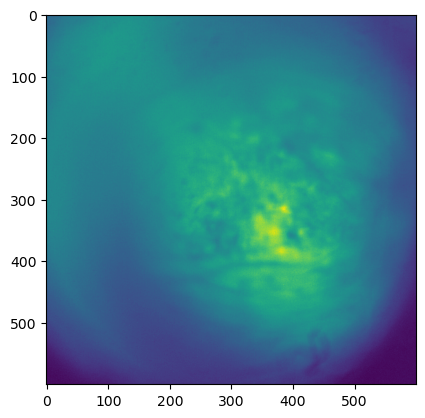

In [13]:
varr_min = varr_ref[frames_without_stripes].min("frame").compute()
plt.imshow(varr_min)

## get file names that need to be replaced

In [14]:


#def get_filename(frame_list):
#    # Get the file names associated with each frame. 
#    vid_numbers = np.unique([math.floor(f/framesPerFile) for f in frame_list])
#    fnames = [os.path.join(dpath, str(n) + '.avi') for n in vid_numbers]
    
    # Get the frame number within that video file. 
#    relative_frame_numbers = []
#    for n in vid_numbers:
#        quotient, remainder = np.divmod(frame_list, n*framesPerFile)
        
#        relative_frame_numbers.append(remainder[(quotient==1) & (remainder < framesPerFile)])
    
#    return fnames, relative_frame_numbers

In [15]:
def get_num_frames(video_file):
    # This function should return the number of frames in the given video file.
    # You can use any method you've previously used to determine the frame count.
    cap = cv2.VideoCapture(video_file)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    cap.release()
    return frame_count

def get_filename(frame_list, param_load_videos=None):
    if not param_load_videos or "pattern" not in param_load_videos:
        pattern = r"[0-9]+\.avi$"
    else:
        pattern = param_load_videos["pattern"]
    
    all_files = natsorted([os.path.join(dpath, f) for f in os.listdir(dpath) if re.search(pattern, f)])

    # Assign start to None if not specified
    start = param_load_videos.get('start') if param_load_videos else None

    # Modify the list comprehension
    if start is not None:
        all_files = [f for f in all_files if int(re.search(r'(\d+)', os.path.basename(f)).group(1)) >= start]


    frames_per_file = [get_num_frames(f) for f in all_files]
    cumulative_frames = np.insert(np.cumsum(frames_per_file), 0, 0)

    grouped_frames = defaultdict(list)

    for frame in frame_list:
        idx = np.digitize(frame, cumulative_frames) - 1
        fname = all_files[idx]
        relative_frame = frame - cumulative_frames[idx]
        grouped_frames[fname].append(relative_frame)

    fnames = list(grouped_frames.keys())
    frame_numbers = list(grouped_frames.values())

    return fnames, frame_numbers


In [16]:
fnames, frame_numbers = get_filename(bad_frames, param_load_videos)
for fname, frames in zip(fnames, frame_numbers):
    print(f"File: {fname}, Bad Frames: {frames}")

File: /scratch/09117/xz6783/minian/Satiation/Session Combined/1H6/17.avi, Bad Frames: [68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 

# Realignment

## move the original files to a new folder and then write a new file with fixed frames\

The function below makes a folder called "originals" and moves the original file there. Then it writes a new video file with the same name to replace it, but with the frames fixed. 

In [17]:
# def fix_frame(frame, shift_amount=8076*2, show_plot=False, ax=None):
#     buffer_size = 8076
#     flattened_frame = frame.flatten()
#     frame_size = frame.shape
#     n_pixels = len(flattened_frame)
    
#     for pixel_number in range(n_pixels):
#         buf_num = int(pixel_number/buffer_size)
        
#         if ((buf_num % 2) == 0):
#             if ((pixel_number + shift_amount) < n_pixels):
#                 flattened_frame[pixel_number] = flattened_frame[pixel_number + shift_amount]
    
#     fixed_frame = flattened_frame.reshape(frame_size)
    
#     if show_plot:
#         if ax is None:
#             fig, ax = plt.subplots(figsize=(24,24))
#         ax.imshow(fixed_frame)
    
#     return fixed_frame

# def fix_video(fnames, frame_numbers):
#     folder = os.path.join(os.path.split(fnames[0])[0], 'originals')
#     if not os.path.exists(folder):
#         os.mkdir(folder)
#         print(f'Created {folder}')
        
#     compressionCodec = "GREY"
#     codec = cv2.VideoWriter_fourcc(*compressionCodec)
    
#     buffer_size = 8076
#     shift_amount = buffer_size*2
    
#     # For each video...
#     for video, bad_frame_numbers in zip(fnames, frame_numbers):
#         print(f'Rewriting {video}')
#         cap = cv2.VideoCapture(video)
#         rows, cols = int(cap.get(4)), int(cap.get(3))
        
#         fname = os.path.split(video)[1]
#         move_fpath = os.path.join(folder, fname)
        
#         # Move the original file. 
#         if not os.path.exists(move_fpath):
#             shutil.move(video, move_fpath)
#             print(f'Moved {video} to {move_fpath}')
#         else:
#             raise FileExistsError('The folder is already storing an original file. Aborting to prevent overwrite.')

#         writeFile = cv2.VideoWriter(video, codec, 60, (cols,rows), isColor=False)
        
#         for frame_number in tqdm(range(int(cap.get(7)))):
#             ret, frame = cap.read()

#             if ret:
#                 write_frame = frame[:,:,0]

#                 if frame_number in bad_frame_numbers:
#                     write_frame = fix_frame(write_frame, shift_amount, show_plot=False)

#                 writeFile.write(np.uint8(write_frame))
#             else:
#                 break

#         writeFile.release()
#         cap.release()
#     cv2.destroyAllWindows()
                

In [247]:
# fix_video(fnames, frame_numbers)

Rewriting /scratch/09117/xz6783/minian/Satiation/Session Combined/1H6/17.avi
Moved /scratch/09117/xz6783/minian/Satiation/Session Combined/1H6/17.avi to /scratch/09117/xz6783/minian/Satiation/Session Combined/1H6/originals/17.avi


100%|██████████| 1000/1000 [01:00<00:00, 16.40it/s]


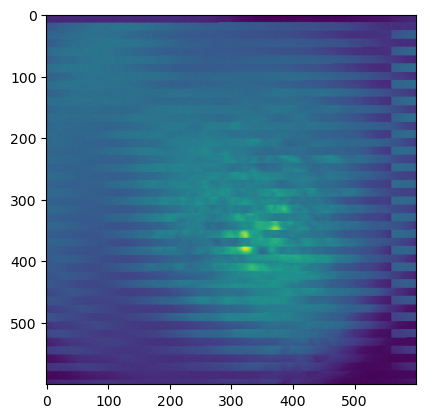

In [87]:
plt.imshow(varr_ref[69].values)

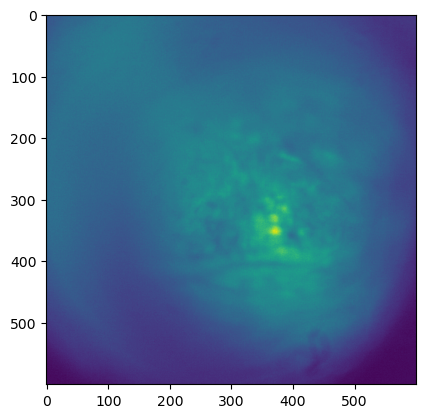

In [88]:
plt.imshow(varr_ref[67].values)

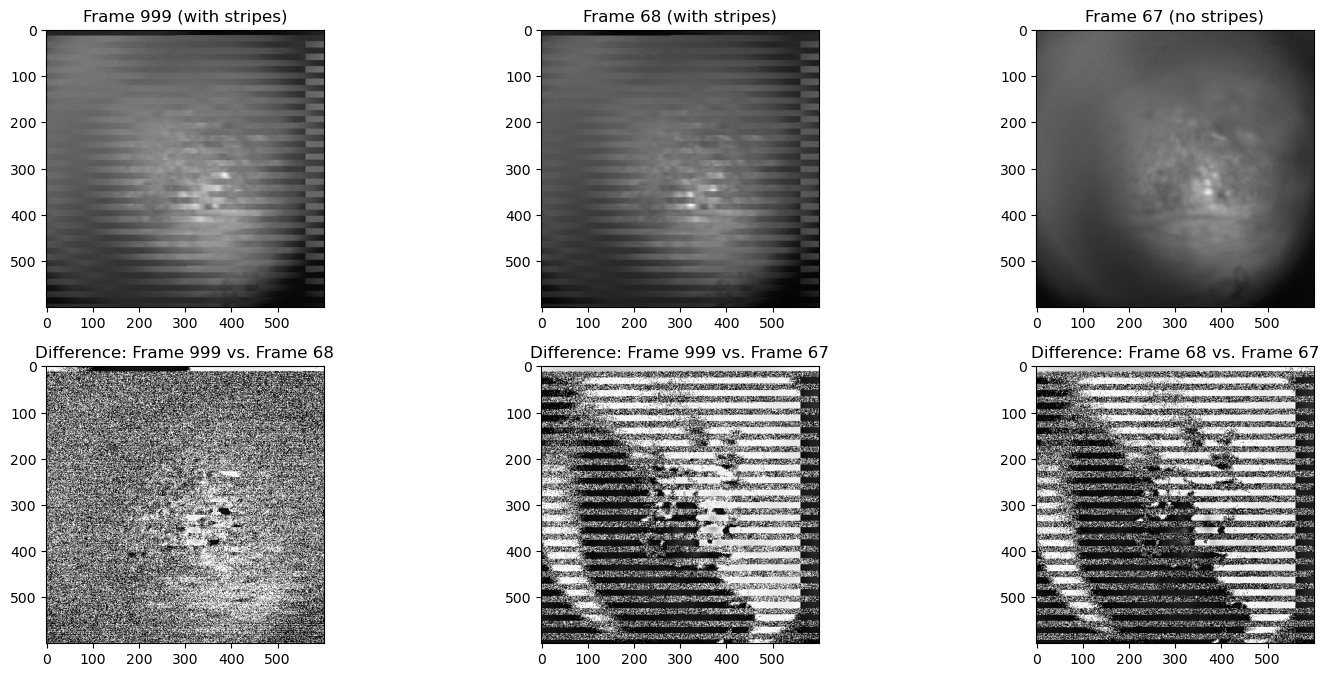

In [597]:
# Plot the frames and their differences
plt.figure(figsize=(15, 10))

# Frame 1000
plt.subplot(3, 3, 1)
plt.imshow(varr_ref[999].values, cmap='gray')
plt.title('Frame 999 (with stripes)')

# Frame 68
plt.subplot(3, 3, 2)
plt.imshow(varr_ref[68].values, cmap='gray')
plt.title('Frame 68 (with stripes)')

# Frame 67
plt.subplot(3, 3, 3)
plt.imshow(varr_ref[67].values, cmap='gray')
plt.title('Frame 67 (no stripes)')

# Difference: Frame 999 vs. Frame 68
plt.subplot(3, 3, 4)
plt.imshow(np.abs(varr_ref[999].values - varr_ref[68].values), cmap='gray')
plt.title('Difference: Frame 999 vs. Frame 68')

# Difference: Frame 1000 vs. Frame 67
plt.subplot(3, 3, 5)
plt.imshow(np.abs(varr_ref[999].values - varr_ref[67].values), cmap='gray')
plt.title('Difference: Frame 999 vs. Frame 67')

# Difference: Frame 68 vs. Frame 67
plt.subplot(3, 3, 6)
plt.imshow(np.abs(varr_ref[68].values - varr_ref[67].values), cmap='gray')
plt.title('Difference: Frame 68 vs. Frame 67')

plt.tight_layout()
plt.show()


In [20]:
# def moving_avg(arr, window_size):
#     i = 0
#     # Initialize an empty list to store moving averages 
#     moving_averages = np.array([]) 

#     # Loop through the array t o 
#     #consider every window of size window_size 
#     while i < len(arr) - window_size + 1: 

#         # Calculate the average of current window 
# #         window_average = round(np.sum(arr[ 
# #           i:i+window_size]) / window_size, 2) 
        
#         window_score = zscore(arr[i:i+window_size])

#         # Store the average of current 
#         # window in moving average list
#         moving_averages = np.concatenate([moving_averages, window_score])

#         # Shift window to right by one position 
#         i += window_size
        
#     moving_averages = np.concatenate([moving_averages, zscore(arr[i::])])

#     return moving_averages

# def find_anchors(write_frame, ref_frame, int_thres=-2.5, deviation=50, exp_buffer_size = 8076):
#     #frame = np.abs(write_frame-ref_frame)
#     fm_flt = write_frame.flatten().astype(float)
#     ref_flt = ref_frame.flatten().astype(float)
#     fm_size = len(fm_flt)
#     fm_diff = np.abs(np.diff(fm_flt))
#     diff_fm = np.abs(fm_flt - ref_flt)
# #     diff_fm_diff = zscore(np.gradient(np.diff(diff_fm)))
#     diff_fm_diff = moving_avg(savgol_filter(np.diff(diff_fm), 30, 4),16200)
    
#     anchors_initial = np.where(diff_fm_diff < int_thres)[0]
#     anchors = []
#     for ibuf, buf in enumerate(np.diff(anchors_initial)):
#         if (buf > (exp_buffer_size - deviation)) & (buf < (exp_buffer_size + deviation)):
#             anchors.append(anchors_initial[ibuf])
#     anchors = np.unique(anchors)
    
#     return anchors

# write_frame = varr_ref[68].values
# ref_frame = varr_ref[67].values
# anchors = []
# anchors = find_anchors(write_frame,ref_frame)
# print("Anchor point:", anchors)
# exp_buffer_size=8076
# search_range = 16
# fm_flt = varr_ref[68].values.flatten().astype(float)
# ref_flt = varr_ref[0].values.flatten().astype(float)
# fm_size = len(fm_flt)
# fm_diff = np.abs(np.diff(fm_flt))
# diff_fm = np.abs(fm_flt - ref_flt)
# buffers = np.arange(anchors[0], 0, (-2) * exp_buffer_size)[::-1]
# for ibuf, buf in enumerate(anchors):
#     try:
#         end = anchors[ibuf + 1] - search_range
#     except IndexError:
#         end = fm_size
#     buffers = np.append(buffers, np.arange(buf, end, 2 * exp_buffer_size))
# buffers = np.unique(buffers) + 1
# buffers = np.stack([buffers, buffers + exp_buffer_size], axis=-1)
# # refine buffers
# for idxbuf, buf in np.ndenumerate(buffers):
#     idx = np.arange(
#         max(buf - search_range, 0), min(buf + search_range, fm_size - 2)
#     )
#     diffs = fm_diff[idx]
#     if len(idx) > 0 and ((max(diffs) - min(diffs)) > 0):
#         buffers[idxbuf] = idx[np.argmax(diffs)] + 1
# buffers

Anchor point: [  8093 105013 298824]


array([[  8080,  16160],
       [ 24234,  32312],
       [ 40384,  48464],
       [ 56536,  64616],
       [ 72697,  80781],
       [ 88857,  96939],
       [105000, 113092],
       [121152, 129244],
       [137304, 145380],
       [153461, 161558],
       [169608, 177710],
       [185760, 193852],
       [201912, 209992],
       [218064, 226160],
       [234216, 242296],
       [250368, 258448],
       [266520, 274600],
       [282675, 290752],
       [298824, 306904],
       [314984, 323056],
       [331137, 339208],
       [347288, 355344]])

In [34]:
# def moving_avg(arr, window_size):
#     i = 0
#     # Initialize an empty list to store moving averages 
#     moving_averages = np.array([]) 

#     # Loop through the array t o 
#     #consider every window of size window_size 
#     while i < len(arr) - window_size + 1: 

#         # Calculate the average of current window 
# #         window_average = round(np.sum(arr[ 
# #           i:i+window_size]) / window_size, 2) 
        
#         window_score = zscore(arr[i:i+window_size])

#         # Store the average of current 
#         # window in moving average list
#         moving_averages = np.concatenate([moving_averages, window_score])

#         # Shift window to right by one position 
#         i += window_size
        
#     moving_averages = np.concatenate([moving_averages, zscore(arr[i::])])

#     return moving_averages

# int_thres=-2.5
# deviation=100
# exp_buffer_size = 8076

# write_frame = varr_ref[68].values
# ref_frame = varr_ref[67].values

# fm_flt = write_frame.flatten().astype(float)
# ref_flt = ref_frame.flatten().astype(float)
# fm_size = len(fm_flt)
# fm_diff = np.abs(np.diff(fm_flt))
# diff_fm = np.abs(fm_flt - ref_flt)
# #     diff_fm_diff = zscore(np.gradient(np.diff(diff_fm)))
# #diff_fm_diff =  butter_bandpass_filter(np.diff(diff_fm), lowcut, highcut, fs) 
# diff_fm_diff = moving_avg(savgol_filter(np.diff(diff_fm), 30, 4),16200)

# np.place(diff_fm_diff, (np.arange(len(diff_fm_diff)) % 600) == 0, 0)
# anchors_initial = np.where(diff_fm_diff < int_thres)[0]
# anchors = []
# for ibuf, buf in enumerate(np.diff(anchors_initial)):
#     if (buf > (exp_buffer_size - deviation)) & (buf < (exp_buffer_size + deviation)):
#         anchors.append(anchors_initial[ibuf])
# anchors = np.unique(anchors)

# print("Anchor point:", anchors)
# exp_buffer_size=8076
# search_range = 16

# # construct initial buffers
# buffers = np.arange(anchors[0], 0, -2 * exp_buffer_size)[::-1]
# for ibuf, buf in enumerate(anchors):
#     try:
#         end = anchors[ibuf + 1] - search_range
#     except IndexError:
#         end = fm_size
#     buffers = np.append(buffers, np.arange(buf, end, 2 * exp_buffer_size))
# buffers = np.unique(buffers) + 1
# buffers = np.stack([buffers, buffers + exp_buffer_size], axis=-1)
# # refine buffers
# for idxbuf, buf in np.ndenumerate(buffers):
#     idx = np.arange(
#         max(buf - search_range, 0), min(buf + search_range, fm_size - 2)
#     )
#     diffs = fm_diff[idx]
#     if len(idx) > 0 and ((max(diffs) - min(diffs)) > 0):
#         buffers[idxbuf] = idx[np.argmax(diffs)] + 1

# buffers

Anchor point: [  8093 105013 282605 298824]


array([[  8080,  16160],
       [ 24234,  32312],
       [ 40384,  48464],
       [ 56536,  64616],
       [ 72697,  80781],
       [ 88857,  96939],
       [105000, 113092],
       [121152, 129244],
       [137304, 145380],
       [153461, 161558],
       [169608, 177710],
       [185760, 193852],
       [201912, 209992],
       [218064, 226160],
       [234216, 242296],
       [250368, 258448],
       [266520, 274600],
       [282594, 290690],
       [298760, 306824],
       [298824, 306904],
       [314984, 323056],
       [331137, 339208],
       [347288, 355344]])

In [62]:
write_frame = varr_ref[68].values
ref_frame = varr_ref[67].values
# def compute_thresholds(arr, window_size, init_thresh): #int_thresh
#     ret = np.cumsum(arr, dtype=float)
#     ret[window_size:] = ret[window_size:] - ret[:-window_size] #int_thresh + max or max difference
#     return ret[window_size - 1:] / window_size

def moving_avg(arr, window_size):
    i = 0
    # Initialize an empty list to store moving averages 
    moving_averages = np.array([]) 

    # Loop through the array t o 
    #consider every window of size window_size 
    while i < len(arr) - window_size + 1: 

        # Calculate the average of current window 
#         window_average = round(np.sum(arr[ 
#           i:i+window_size]) / window_size, 2) 
        
        window_score = zscore(arr[i:i+window_size])

        # Store the average of current 
        # window in moving average list
        moving_averages = np.concatenate([moving_averages, window_score])

        # Shift window to right by one position 
        i += window_size
        
    moving_averages = np.concatenate([moving_averages, zscore(arr[i::])])

    return moving_averages


def compute_thresholds(arr, window_size, init_thresh):
    ret = np.zeros(math.ceil(len(arr)/window_size), dtype = float)
    
    for i in range(math.ceil(len(arr)/window_size)):
        ref_i = window_size * i
        window = arr[ref_i: ref_i + window_size]        
        window = window[np.where(window>=0)[0]]
        max_diff = np.max(window) - np.min(window)
        ret[i] = init_thresh + max_diff
    
    return ret

def find_dynamic_anchors(write_frame, ref_frame, window_size=8076*2, deviation=100, exp_buffer_size=8076, init_thresh=-2):
    fm_flt = write_frame.flatten().astype(float)
    ref_flt = ref_frame.flatten().astype(float)
    fm_size = len(fm_flt)
    fm_diff = np.abs(np.diff(fm_flt))
    diff_fm = np.abs(fm_flt - ref_flt)
    diff_fm_diff = moving_avg(savgol_filter(np.diff(diff_fm), 30, 4), 16200)
    
    # Compute dynamic thresholds
    dynamic_thresh = compute_thresholds(diff_fm_diff, window_size, init_thresh)
    
    np.place(diff_fm_diff, (np.arange(len(diff_fm_diff)) % 600) == 0, 0)
    
    # Step 1: Identify the initial anchor points using dynamic_thresh
    anchors_initial = []
    for i in range(math.ceil(len(diff_fm_diff)/window_size)):
        ref_i = window_size * i
        anchors_initial.extend(np.where(diff_fm_diff[ref_i: ref_i + window_size]  > dynamic_thresh[i])[0]+ref_i)
        
#     anchors_initial = np.where(diff_fm_diff[window_size - 1:] > dynamic_thresh)[0] # loop over the window
    if len(anchors_initial) == 0:
        return []
    anchors = []
    for ibuf, buf in enumerate(np.diff(anchors_initial)):
        if (buf > (exp_buffer_size - deviation)) & (buf < (exp_buffer_size + deviation)):
            # window_size - 1 is offset from dynamic threshold
            anchors.append(anchors_initial[ibuf] + window_size - 1)  
    
    anchors = np.unique(anchors)
    return anchors, anchors_initial

In [64]:
anchors, anchors_initial = find_dynamic_anchors(write_frame, ref_frame)
anchors

array([153381, 314939, 331112])

In [73]:
# Refining Buffer Construction
def generate_refined_buffers(anchors, dynamic_thresh, expected_strips=22, exp_buffer_size=8076, 
                              frame_limit=600*600, deviation=100, search_range=16, diff_fm=None, anchors_initial=None):
    # Initialize variables
    refined_buffers = []
    
    # Start with the first buffer point as 0
    current_point = 0

    # Loop through expected number of strips
    for _ in range(expected_strips):
        # Look for a potential anchor within a specific range around exp_buffer_size
        search_start = current_point + exp_buffer_size - search_range
        search_end = current_point + exp_buffer_size + search_range

        potential_anchors = [anchor for anchor in anchors if search_start <= anchor <= search_end]

        # If an anchor is found within the range
        if potential_anchors:
            # Replace end point with anchor
            end_point = potential_anchors[0]
            
            # Find the corresponding entries in anchors_initial 
            indices = np.where(anchors_initial == potential_anchors[0])[0]
            if indices.size > 0 and indices[0] + 1 < len(anchors_initial):
                next_start = anchors_initial[indicies[0] + 1]
        else:
            # Define end_point as current_point += exp_buffer_size
            # Additionally Check if the last buffer could exceed frame limit
            end_point = min(current_point + exp_buffer_size, frame_limit - 1)
            next_start = end_point + exp_buffer_size
 
        # Add current buffer to the list
        refined_buffers.append((current_point, end_point))

        # Update current_point for the next iteration
        current_point = next_start
        
    refined_buffers = np.array(refined_buffers)
    
    # Additional buffer refinement using diff_fm 
    if diff_fm is not None:
        for idxbuf, buf in np.ndenumerate(refined_buffers):
            """ OLD IMPLEMENTATION:
            
            idx = np.arange(
                max(buf - search_range, 0), min(buf + search_range, fm_size - 2)
            )
            diffs = diff_fm[idx]
            if len(idx) > 0 and ((max(diffs) - min(diffs)) > 0):
                refined_buffers[idxbuf] = idx[np.argmax(diffs)] + 1

            """

            # Define the search area
            search_start = max(buf - search_range, 0)
            search_end = min(buf + search_range, frame_limit - 1)
        
            # Define local threshold
            local_thresh = dynamic_thresh[search_start: search_end]
            
            # The indicies that meet the threshold criteria
            candidate_indicies = np.where(diff_fm[search_start: search_end] >= local_thresh)[0]
            
            # Fix offset to match original diff_fm
            candidate_indicies += search_start

            if idxbuf[1] % 2 == 0 and idxbuf[1] != 0:
                # Set as first pixel that reaches threshold for start of buffer, except for first buffer
                    if candidate_indicies:
                        refined_buffers[idxbuf] = candidate_indicies[0]
            elif idxbuf[1] % 2 != 0 and idxbuf[1] != 0:
                # Set as last pixel that reaches threshold for end of buffer
                if candidate_indicies:
                    refined_buffers[idxbuf] = candidate_indicies[-1]
        
    
    return np.array(refined_buffers)

buffers_generated = generate_refined_buffers(anchors, diff_fm = diff_fm, anchors_initial = anchors_initial, dynamic_thresh = dynamic_thresh)
buffers_generated

ValueError: operands could not be broadcast together with shapes (32,) (0,) 

In [ ]:
for idxbuf, buf in np.ndenumerate(refined_buffers):

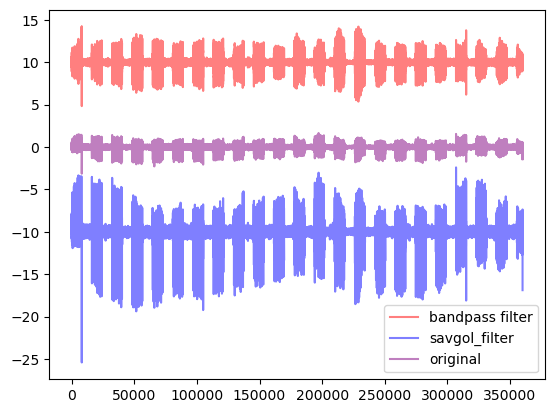

In [68]:
from scipy.signal import butter, filtfilt

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y

# Sample rate and desired cutoff frequencies (in Hz).
fs = 1.0  # Assuming 1Hz for this example, adjust as per your data
lowcut = 0.02
highcut = 0.04

filtered_data = butter_bandpass_filter(diff_fm_diff, lowcut, highcut, fs)
plt.plot(filtered_data+10, c = 'red', alpha = 0.5, label = "bandpass filter")

from scipy.signal import savgol_filter
plt.plot(savgol_filter(diff_fm_diff, 30, 4)-10, c = 'b', alpha = 0.5, label = "savgol_filter") 


plt.plot(diff_fm_diff*0.2, c = 'purple', alpha = 0.5,  label = "original")
plt.legend(loc="best")
plt.show()

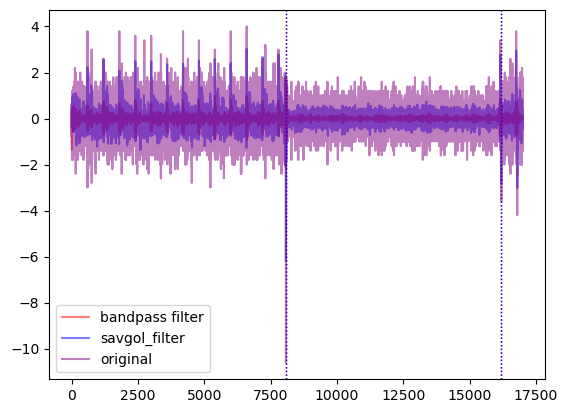

In [25]:
diff_fm = np.abs(fm_flt - ref_flt)
diff_fm_diff = np.diff(diff_fm)
plt.plot(filtered_data[:17000], c = 'red', alpha = 0.5, label = "bandpass filter")
plt.plot(savgol_filter(diff_fm_diff, 30, 4)[:17000], c = 'b', alpha = 0.5, label = "savgol_filter") 
plt.plot(diff_fm_diff[:17000]*0.2, c = 'purple', alpha = 0.5,  label = "original")
plt.axvline(anchors_initial[np.where(np.diff(anchors_initial) > 7000)[0]][0], c = 'r', lw = 1, linestyle=':')
plt.axvline(anchors_initial[np.where(np.diff(anchors_initial) > 7000)[0]+1][0], c = 'r', lw = 1, linestyle=':')
plt.axvline(buffers[0,0], c = 'b', lw = 1, linestyle=':')
plt.axvline(buffers[0,1], c = 'b', lw = 1, linestyle=':')
plt.legend(loc="best")
plt.show()

In [163]:
#orginal code from Phill
def determine_buffers(
    frame, ref_frame, exp_buffer_size=8076, int_thres=20, search_range=16
):
    # find anchors
    fm_flt = frame.flatten().astype(float)
    ref_flt = ref_frame.flatten().astype(float)
    fm_size = len(fm_flt)
    fm_diff = np.abs(np.diff(fm_flt))
    diff_fm = np.abs(fm_flt - ref_flt)
    diff_fm_diff = np.diff(diff_fm)
    np.place(diff_fm_diff, (np.arange(len(diff_fm_diff)) % 600) == 0, 0)
    anchors_initial = np.where(diff_fm_diff > int_thres)[0]
    anchors = []
    for ibuf, buf in enumerate(np.diff(anchors_initial)):
        if buf == exp_buffer_size * 2:
            anchors.append(anchors_initial[ibuf])
    anchors = np.unique(anchors)
    # construct initial buffers
    buffers = np.arange(anchors[0], 0, -2 * exp_buffer_size)[::-1]
    for ibuf, buf in enumerate(anchors):
        try:
            end = anchors[ibuf + 1] - search_range
        except IndexError:
            end = fm_size
        buffers = np.append(buffers, np.arange(buf, end, 2 * exp_buffer_size))
    buffers = np.unique(buffers) + 1
    buffers = np.stack([buffers, buffers + exp_buffer_size], axis=-1)
    # refine buffers
    for idxbuf, buf in np.ndenumerate(buffers):
        idx = np.arange(
            max(buf - search_range, 0), min(buf + search_range, fm_size - 2)
        )
        diffs = diff_fm[idx]
        if len(idx) > 0 and ((max(diffs) - min(diffs)) > 0):
            buffers[idxbuf] = idx[np.argmax(diffs)] + 1
    return buffers, anchors, anchors_initial

buffers, anchors, anchors_initial = determine_buffers(write_frame, ref_frame)

In [165]:
buffers

array([[    25,   8078],
       [ 16179,  24230],
       [ 32313,  40382],
       [ 48480,  56533],
       [ 64630,  72686],
       [ 80774,  88846],
       [ 96934, 104993],
       [113083, 121152],
       [129218, 137295],
       [145381, 153453],
       [161529, 169598],
       [177694, 185760],
       [193836, 201912],
       [209997, 218063],
       [226155, 234211],
       [242301, 250366],
       [258457, 266519],
       [274607, 282663],
       [290753, 298822],
       [306918, 314982],
       [323071, 331118],
       [339214, 347282],
       [355370, 363436]])

In [164]:
anchors, anchors_initial

(array([290751]),
 array([ 16159,  17359,  19759,  23959,  32359,  33559,  34159,  34759,
         36559,  37159,  37759,  40159, 166759, 169159, 178159, 200769,
        209991, 210965, 231928, 279357, 290751, 306903, 310759, 312559,
        314359]))

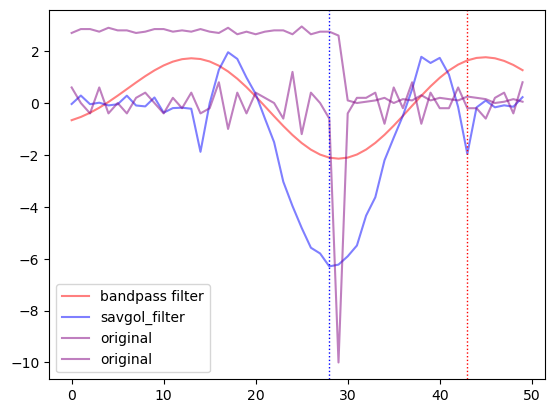

In [38]:
diff_fm = np.abs(fm_flt - ref_flt)
diff_fm_diff = np.diff(diff_fm)
plt.plot(filtered_data[8050:8100], c = 'red', alpha = 0.5, label = "bandpass filter")
plt.plot(savgol_filter(diff_fm_diff, 30, 4)[8050:8100], c = 'b', alpha = 0.5, label = "savgol_filter") 
plt.plot(diff_fm_diff[8050:8100]*0.2, c = 'purple', alpha = 0.5,  label = "original")
plt.plot(diff_fm[8050:8100]*0.05, c = 'purple', alpha = 0.5,  label = "original")
plt.axvline(anchors_initial[np.where(np.diff(anchors_initial) > 7000)[0]][0]-8050, c = 'r', lw = 1, linestyle=':')
#plt.axvline(anchors_initial[np.where(np.diff(anchors_initial) > 7000)[0]+1][0]-8050, c = 'r', lw = 1, linestyle=':')
plt.axvline(buffers_generated[0,0]-8050, c = 'b', lw = 1, linestyle=':')
#plt.axvline(buffers[0,1]-8050, c = 'b', lw = 1, linestyle=':')
plt.legend(loc=0)
plt.show()

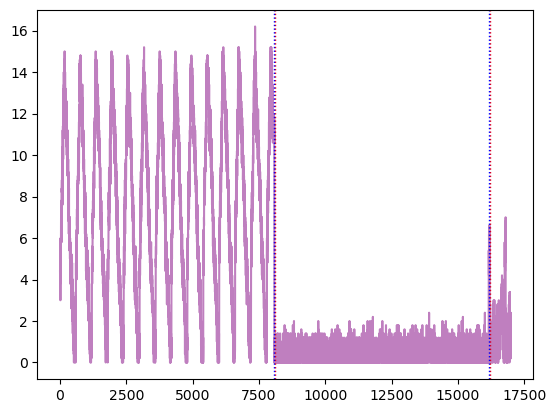

In [689]:
plt.plot(diff_fm[:17000]*0.2, c = 'purple', alpha = 0.5,  label = "original")
plt.axvline(anchors_initial[np.where(np.diff(anchors_initial) > 7000)[0]][0], c = 'r', lw = 1, linestyle=':')
plt.axvline(anchors_initial[np.where(np.diff(anchors_initial) > 7000)[0]+1][0], c = 'r', lw = 1, linestyle=':')
plt.axvline(buffers[0,0], c = 'b', lw = 1, linestyle=':')
plt.axvline(buffers[0,1], c = 'b', lw = 1, linestyle=':')

Text(0.5, 1.0, 'Frame with Whiteout Buffers')

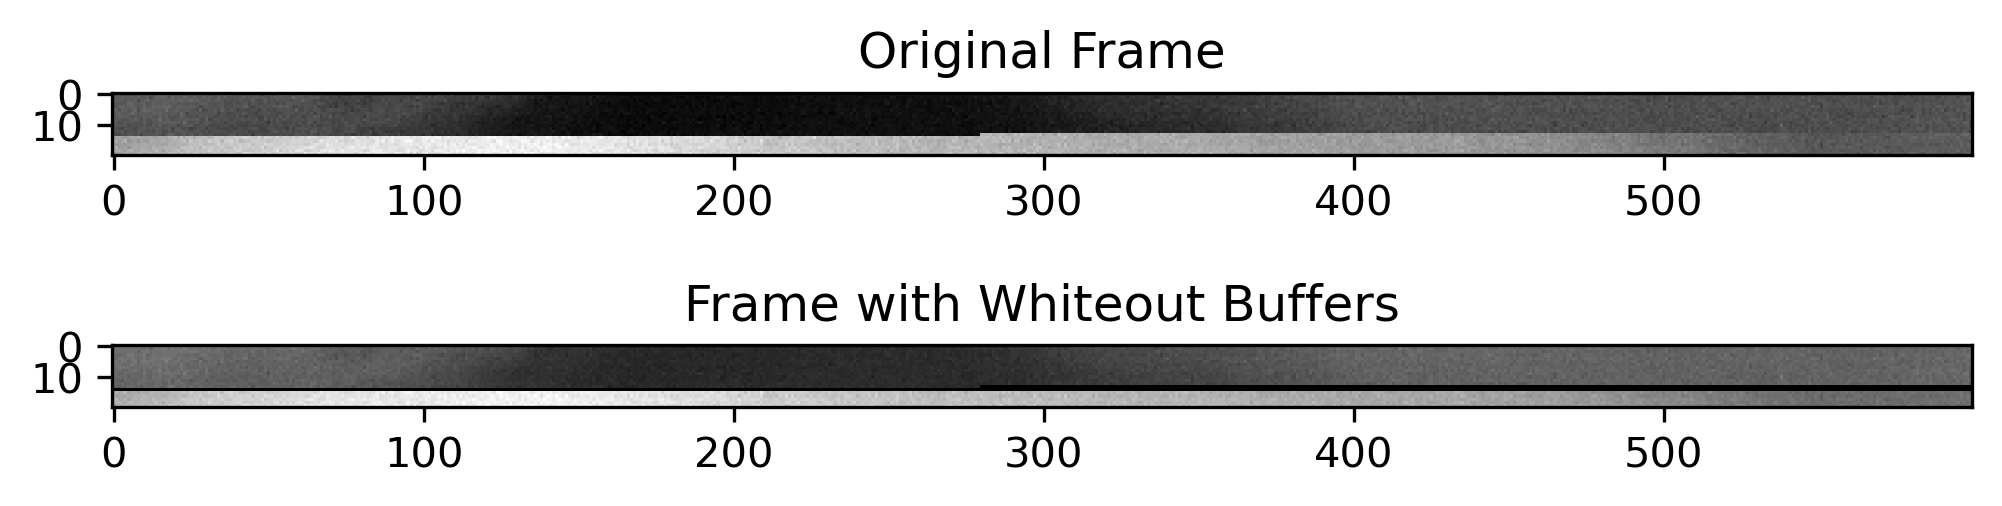

In [71]:
frame = write_frame[0:20,:]
vis_frame = frame.copy()
rows, cols = frame.shape

# Convert flattened indices to 2D coordinates
def idx_to_2d(idx):
    return divmod(idx, cols)


for idx in range(8080,  9000):
        row, col = idx_to_2d(idx)
        vis_frame[row, col] = 0  # Set to white for visualization

        

# Display the frame with all highlighted buffers
# Plot the original and modified frames
plt.figure(figsize=(8, 2), dpi = 300)

plt.subplot(2, 1, 1)
plt.imshow(frame.copy(), cmap='gray')
plt.title("Original Frame")

plt.subplot(2, 1, 2)
plt.imshow(vis_frame, cmap='gray')
plt.title("Frame with Whiteout Buffers")


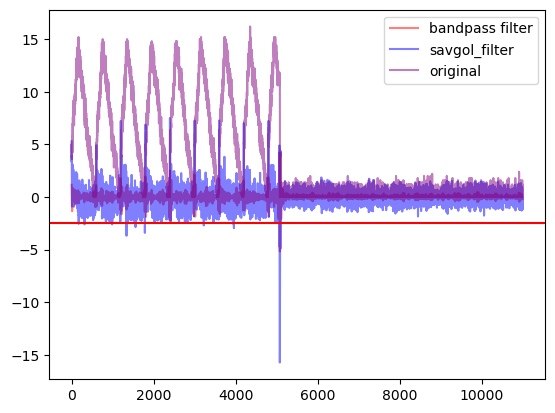

In [656]:
diff_fm = np.abs(fm_flt - ref_flt)
diff_fm_diff = moving_avg(savgol_filter(np.diff(diff_fm), 30, 4), 16200)
plt.plot(filtered_data[3000:14000], c = 'red', alpha = 0.5, label = "bandpass filter")
plt.plot(diff_fm_diff[3000:14000], c = 'b', alpha = 0.5, label = "savgol_filter") 
plt.plot(diff_fm[3000:14000]*0.2, c = 'purple', alpha = 0.5,  label = "original")
plt.axhline(-2.5, c = 'r')
plt.legend(loc="best")
plt.show()

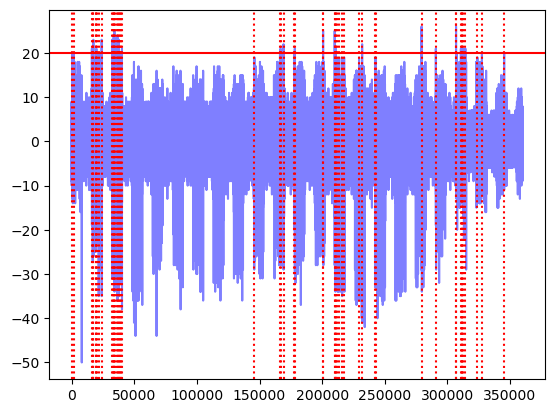

In [126]:
diff_fm = np.abs(fm_flt - ref_flt)
diff_fm_diff = np.diff(diff_fm)
plt.plot(diff_fm_diff, c = 'b', alpha = 0.5, label = "savgol_filter") 
plt.axhline(20, c = 'r')
for start in anchors_initial:
    plt.axvline(start, color='red', linestyle=':')


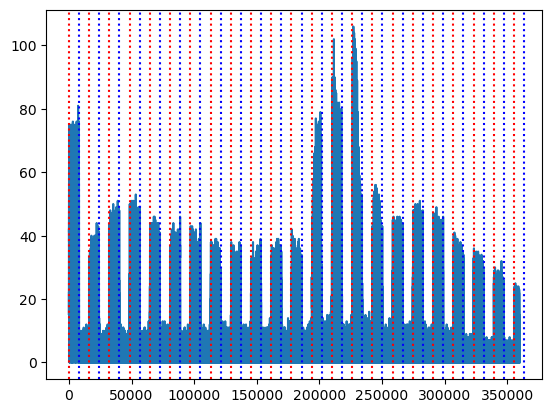

In [129]:
diff_fm = np.abs(fm_flt - ref_flt)
diff_fm_diff = np.diff(diff_fm)
plt.plot(diff_fm)
for start,stop in buffers:
    plt.axvline(start, color='red', linestyle=':')
    plt.axvline(stop, color='blue', linestyle=':')

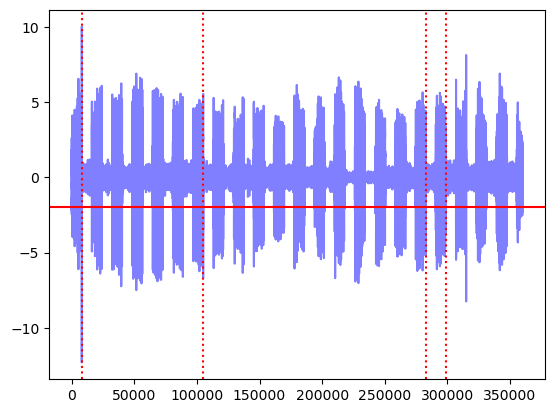

In [691]:
diff_fm = np.abs(fm_flt - ref_flt)
diff_fm_diff = np.diff(diff_fm)
plt.plot(moving_avg(butter_bandpass_filter(diff_fm_diff, lowcut, highcut, fs), 16200), c = 'b', alpha = 0.5, label = "savgol_filter") 
plt.axhline(-2, c = 'r')
for start in anchors:
    plt.axvline(start, color='red', linestyle=':')

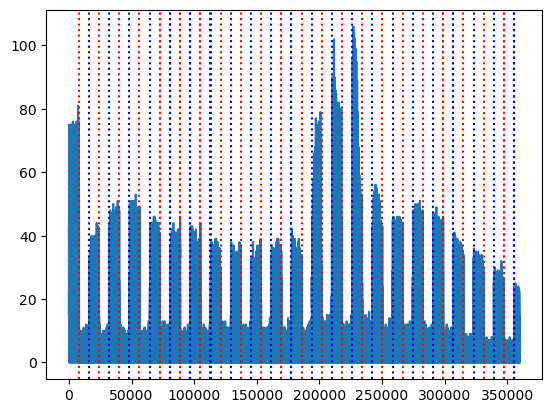

In [630]:
plt.plot(diff_fm)
for start,stop in buffers:
    plt.axvline(start, color='red', linestyle=':')
    plt.axvline(stop, color='blue', linestyle=':')

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [ 28,  29,  31, ...,  22,  25,  24],
       [ 29,  29,  29, ...,  23,  24,  25],
       [ 29,  30,  33, ..., 255, 255,  22]], dtype=uint8)

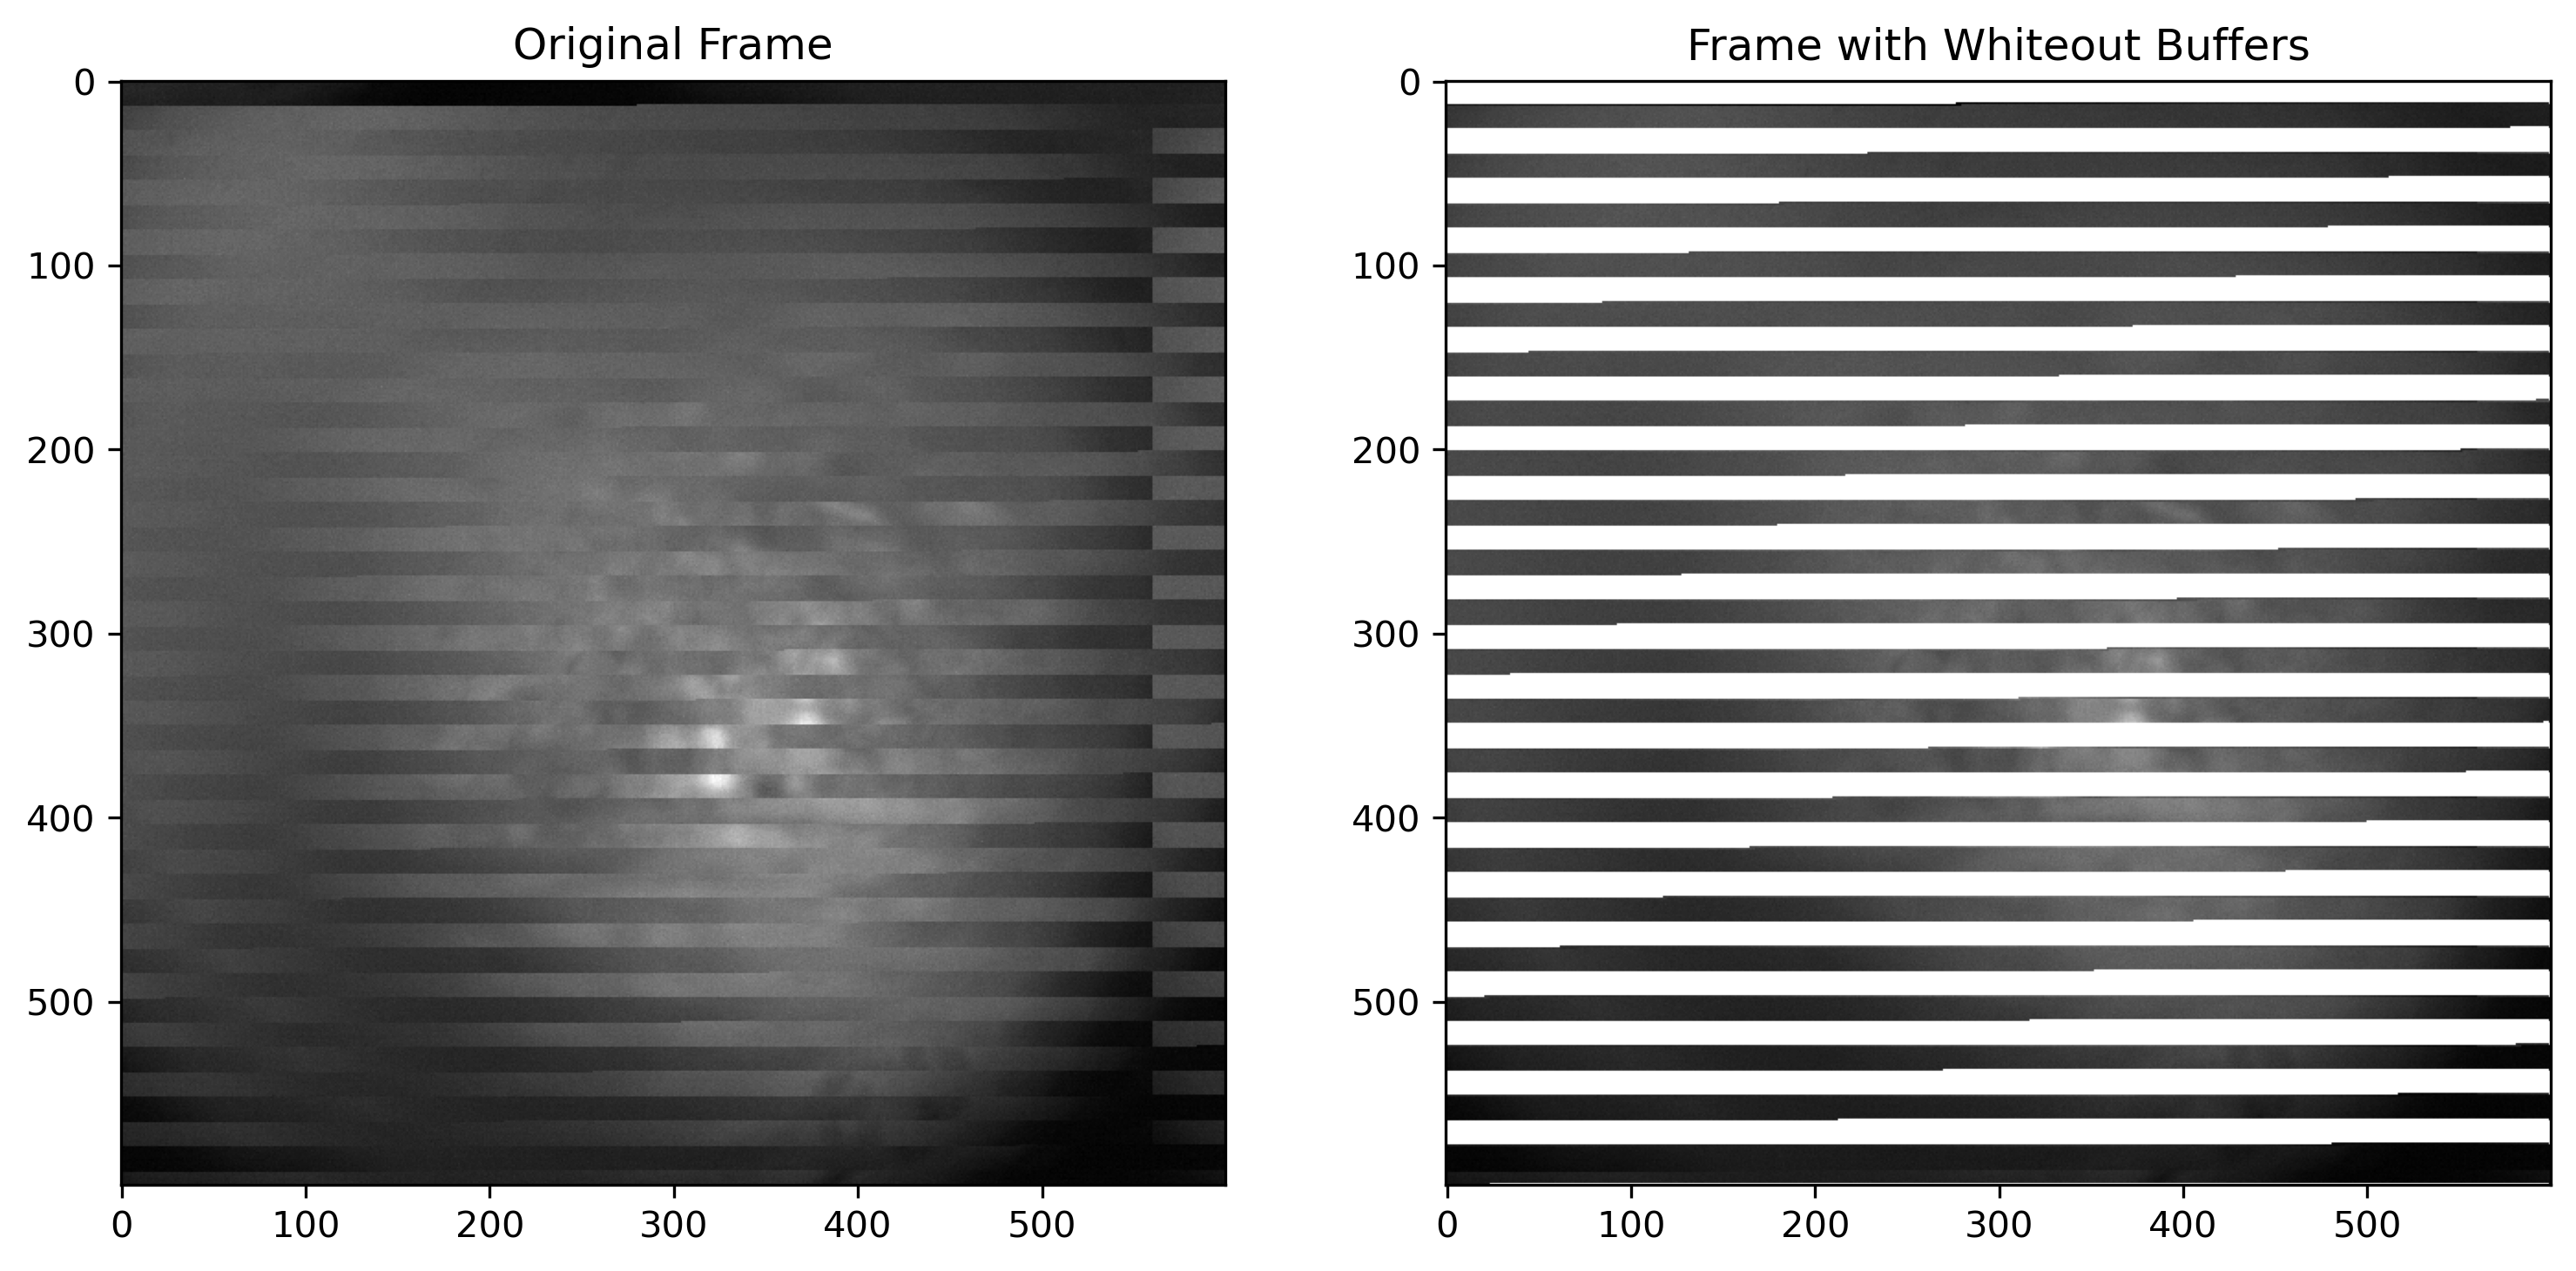

In [235]:
def visualize_all_buffers(frame, buffers):
    """
    Visualize all buffers on the original frame.

    Parameters:
    - frame: 2D array representing the frame.
    - buffers: Array of shape (N, 2) where each row contains the start and end indices of a buffer.

    Returns:
    - vis_frame: Frame with all buffers highlighted.
    """
    vis_frame = frame.copy()
    rows, cols = frame.shape

    # Convert flattened indices to 2D coordinates
    def idx_to_2d(idx):
        return divmod(idx, cols)

    # Highlight each buffer region
    for start, end in buffers:
        for idx in range(start, end):
            row, col = idx_to_2d(idx)
            vis_frame[row-1, col-1] = 255  # Set to white for visualization

    # Display the frame with all highlighted buffers
    # Plot the original and modified frames
    plt.figure(figsize=(12, 6), dpi = 300)
    
    plt.subplot(1, 2, 1)
    plt.imshow(frame, cmap='gray')
    plt.title("Original Frame")
    
    plt.subplot(1, 2, 2)
    plt.imshow(vis_frame, cmap='gray')
    plt.title("Frame with Whiteout Buffers")

    return vis_frame

# Assuming you have already determined the buffers for a frame and have a frame named 'write_frame'
visualize_all_buffers(write_frame, buffers[:-1])



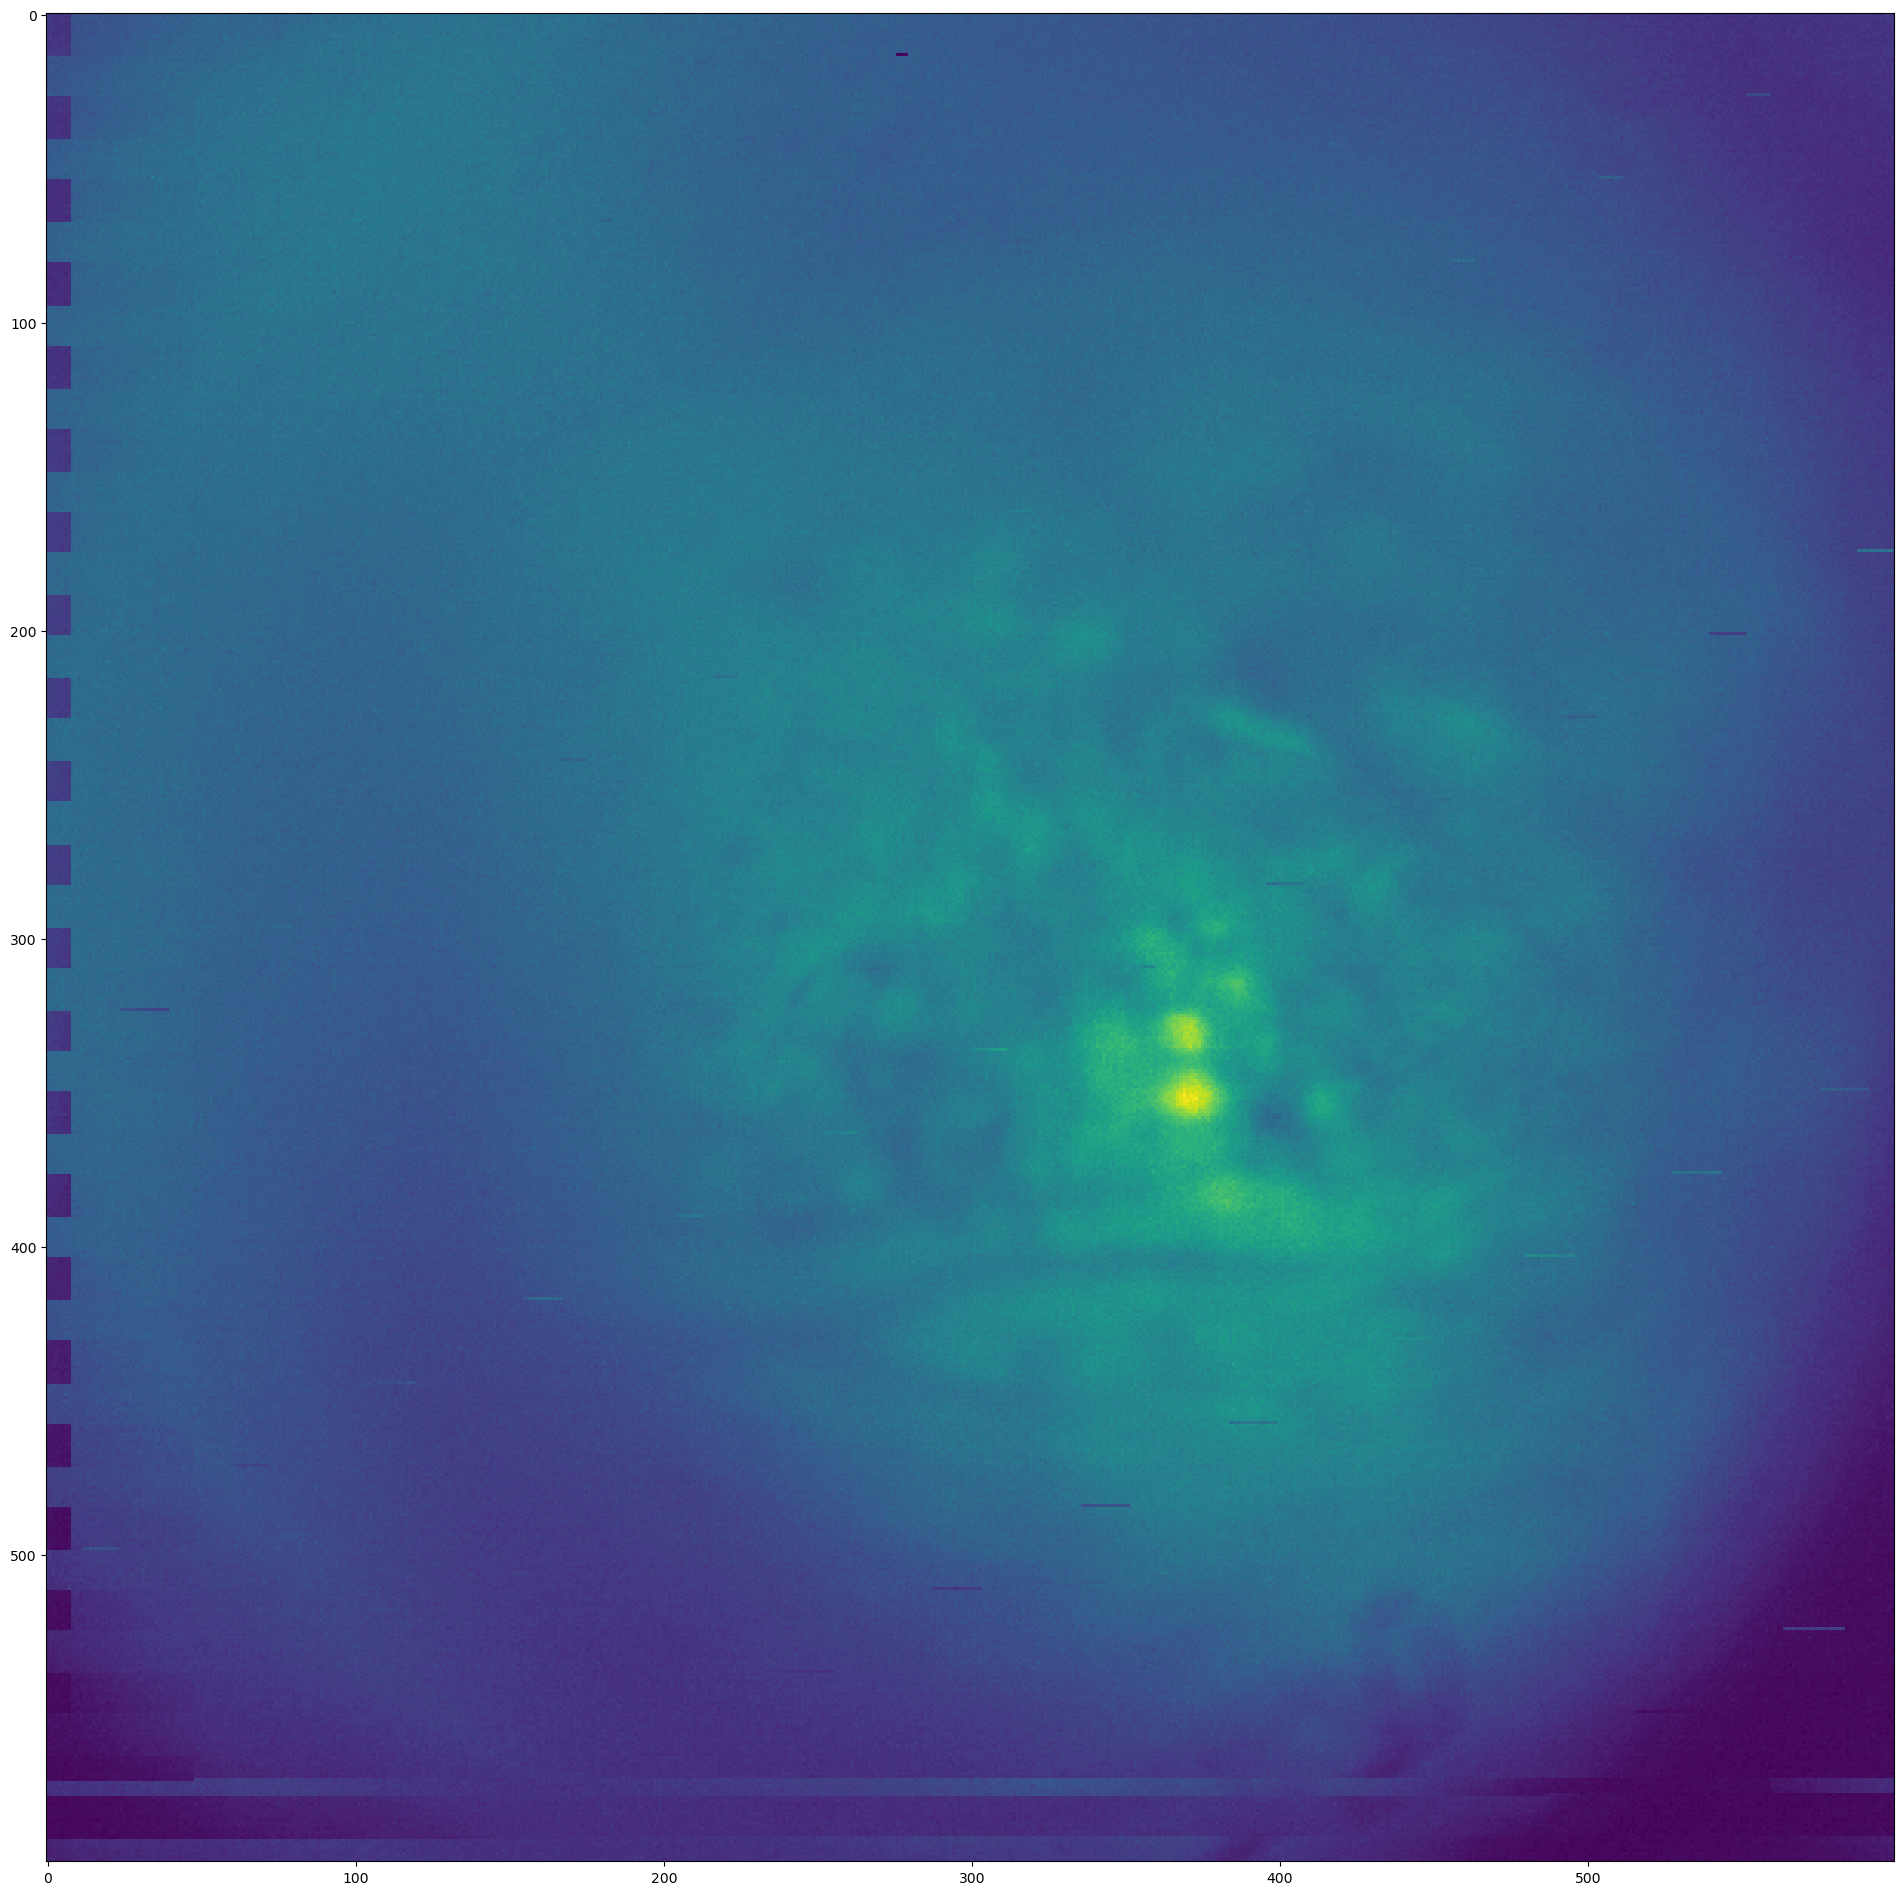

In [162]:
#Original code from Will


# For each video...
for video, bad_frame_numbers in zip(fnames, frame_numbers):
    print(f'Rewriting {video}')
    cap = cv2.VideoCapture(video)
    rows, cols = int(cap.get(4)), int(cap.get(3))

# Set the position to the 68th frame
cap.set(cv2.CAP_PROP_POS_FRAMES, 68)

# Read the frame
ret, frame = cap.read()

write_frame = frame[:,:,0]
show_plot = True
shift_amount=8076*2
bufNum = 0
frame = write_frame
buffer_size = 8076
flattened_frame = frame.flatten()
frame_size = frame.shape
n_pixels = len(flattened_frame)

for pixel_number in range(n_pixels):
    buf_num = int(pixel_number/buffer_size)

    if ((buf_num % 2) == 0):
        if ((pixel_number + shift_amount) < n_pixels):
            flattened_frame[pixel_number] = flattened_frame[pixel_number + shift_amount]

fixed_frame = flattened_frame.reshape(frame_size)

if show_plot:
   
    fig, ax = plt.subplots(figsize=(24,24))
    ax.imshow(fixed_frame)


In [79]:
#Final function list to be modifed

def find_anchors(write_frame, ref_frame, thresh=3.3, deviation=500, exp_buffer_size = 8076):
    #frame = np.abs(write_frame-ref_frame)
    fm_flt = write_frame.flatten().astype(float)
    ref_flt = ref_frame.flatten().astype(float)
    fm_size = len(fm_flt)
    fm_diff = np.abs(np.diff(fm_flt))
    diff_fm = np.abs(fm_flt - ref_flt)
    diff_fm_diff = zscore(np.gradient(np.diff(diff_fm)))
    np.place(diff_fm_diff, (np.arange(len(diff_fm_diff)) % 600) == 0, 0)
    anchors = []
    # Step 2: Identify the first anchor point using diff_fm_diff
    first_anchor = np.where(diff_fm_diff>thresh)[0]
    if len(first_anchor) == 0:
        return []
    
    # Step 3: Predict next anchor and find the first peak that exceeds the threshold within the search window
    anchors = [first_anchor[0]]
    while anchors[-1] + 2*exp_buffer_size < fm_size:
        predicted_next_start = anchors[-1] + 2*exp_buffer_size
        search_window = diff_fm_diff[
            max(predicted_next_start - deviation, 0) : min(predicted_next_start + deviation, len(diff_fm_diff))+1
        ]
        next_start_positions = np.where(search_window > thresh)[0]
        if len(next_start_positions) == 0:
            break
        next_start = next_start_positions[0] + (predicted_next_start - deviation)
        anchors.append(next_start)
    
    return anchors

def determine_buffers(
    frame, ref_frame, exp_buffer_size=8076, search_range=16
):
    
    # find anchors
    fm_flt = frame.flatten().astype(float)
    ref_flt = ref_frame.flatten().astype(float)
    fm_size = len(fm_flt)
    fm_diff = np.abs(np.diff(fm_flt))
    diff_fm = np.abs(fm_flt - ref_flt)
    anchors = []
    anchors = find_anchors(frame, ref_frame)
    buffers = np.arange(anchors[0], 0, -2 * exp_buffer_size)[::-1]
    for ibuf, buf in enumerate(anchors):
        try:
            end = anchors[ibuf + 1] - search_range
        except IndexError:
            end = fm_size
        buffers = np.append(buffers, np.arange(buf, end, 2 * exp_buffer_size))
    buffers = np.unique(buffers) + 1
    buffers = np.stack([buffers, buffers + exp_buffer_size], axis=-1)
    # refine buffers
    for idxbuf, buf in np.ndenumerate(buffers):
        idx = np.arange(
            max(buf - search_range, 0), min(buf + search_range, fm_size - 2)
        )
        diffs = fm_diff[idx]
        if len(idx) > 0 and ((max(diffs) - min(diffs)) > 0):
            buffers[idxbuf] = idx[np.argmax(diffs)] + 1
    return buffers


def label_buffer(frame, buffers, include=True):
    fm_flt = frame.flatten()
    if include:
        fm_ret = np.zeros_like(fm_flt)
    else:
        fm_ret = fm_flt.copy()
    for ibuf, buf in enumerate(buffers):
        a, b = buf
        if include:
            fm_ret[a:b] = fm_flt[a:b]
        else:
            fm_ret[a:b] = 0
    return fm_ret.reshape(frame.shape)


def fix_frame(frame, ref_frame, buffers, exp_buffer_size=8076):
    fm_flatten = frame.flatten().astype(float)
    fm_ref_flatten = ref_frame.flatten().astype(float)
    shifts = np.zeros(buffers.shape[0])
    fm_fix = fm_flatten.copy()
    for ibuf, buf in enumerate(buffers):
        a, b = buf
        fm_fix[a:b] = 0
        cur_buf = fm_flatten[a:b]
        cur_ref = fm_ref_flatten[a:b]
        cur_new, cur_mask, sh = shift_buffer(fm_fix[a:b], cur_buf, cur_ref)
        fm_fix[a:b] = cur_new
        idx_missing = np.where(~cur_mask)[0]
        c, d = a + idx_missing.min(), a + idx_missing.max()
        len_missing = d - c
        shifts[ibuf] = sh
        if ibuf > 0:
            j, k = buffers[ibuf - 1]
            assert (k - j) > len_missing
            prev_buf = fm_flatten[(k - len_missing) : k]
            prev_new, prev_mask, sh = shift_buffer(
                cur_new[~cur_mask], prev_buf, cur_ref[~cur_mask]
            )
            fm_fix[c : (d + 1)] = prev_new
    return fm_fix.reshape(frame.shape).astype(frame.dtype), shifts

def shift_buffer(buf_org, buf_repl, buf_ref):
    std_ref = np.std(buf_ref)
    std_repl = np.std(buf_repl)
    if std_ref > 0 and std_repl > 0:
        ref_norm = (buf_ref - buf_ref.mean()) / std_ref
        repl_norm = (buf_repl - buf_repl.mean()) / std_repl
        lags = correlation_lags(len(buf_repl), len(buf_ref), mode="full")
        corr = correlate(repl_norm, ref_norm, mode="full", method="fft")
        sh = -lags[np.argmax(corr)]
    else:
        sh = 0
    len_repl = len(buf_repl) - abs(sh)
    buf_new = buf_org.copy()
    mask = np.zeros_like(buf_org, dtype=bool)
    range_repl = np.arange(max(0, sh), min(len(buf_repl) + sh, len(buf_new)))
    buf_new[range_repl] = buf_repl[range_repl - sh]
    mask[range_repl] = 1
    return buf_new, mask, sh

def fix_video_new(fnames, frame_numbers, varr_ref, frames_without_stripes, bad_frames):
    folder = os.path.join(os.path.split(fnames[0])[0], 'originals')
    if not os.path.exists(folder):
        os.mkdir(folder)
        print(f'Created {folder}')
        
    compressionCodec = "GREY"
    codec = cv2.VideoWriter_fourcc(*compressionCodec)
    
    #reference frame 
    ref_frame = varr_ref[bad_frames[0]-1].values

    
    # For each video...
    for video, bad_frame_numbers in zip(fnames, frame_numbers):
        print(f'Rewriting {video}')
        cap = cv2.VideoCapture(video)
        rows, cols = int(cap.get(4)), int(cap.get(3))
        
        fname = os.path.split(video)[1]
        move_fpath = os.path.join(folder, fname)
        
        # Move the original file. 
        if not os.path.exists(move_fpath):
            shutil.move(video, move_fpath)
            print(f'Moved {video} to {move_fpath}')
        else:
            raise FileExistsError('The folder is already storing an original file. Aborting to prevent overwrite.')

        writeFile = cv2.VideoWriter(video, codec, 60, (cols,rows), isColor=False)
        
        for frame_number in tqdm(range(int(cap.get(7)))):
            ret, frame = cap.read()

            if ret:
                write_frame = frame[:,:,0]

                if frame_number in bad_frame_numbers:
                    # Determine buffers
                    buffers = determine_buffers(write_frame, ref_frame)
                    
                    # Label buffer
                    labeled_frame = label_buffer(write_frame, buffers)
                    
                    # Fix frame
                    fixed_frame, _ = fix_frame(labeled_frame, ref_frame, buffers)
                    write_frame = fixed_frame

                writeFile.write(np.uint8(write_frame))
            else:
                break

        writeFile.release()
        cap.release()
    cv2.destroyAllWindows()


In [19]:
fix_video_new(fnames, frame_numbers, varr_ref, frames_without_stripes, bad_frames)

Rewriting /scratch/09117/xz6783/minian/Satiation/Session Combined/1H6/17.avi
Moved /scratch/09117/xz6783/minian/Satiation/Session Combined/1H6/17.avi to /scratch/09117/xz6783/minian/Satiation/Session Combined/1H6/originals/17.avi


  7%|▋         | 68/1000 [00:00<00:04, 224.50it/s]


ValueError: zero-size array to reduction operation minimum which has no identity

#### New frame fix code

In [256]:


# Extract all buffers
frame = varr_ref[68].values
Fframe = frame.flatten()

all_buffers = [Fframe[start:end] for start, end in buffers]
concatenated_buffer = np.concatenate(all_buffers)

# Circularly shift the concatenated_buffer to start from the second buffer
shift_amount = len(all_buffers[0])
circular_shifted_buffer = np.roll(concatenated_buffer, -shift_amount)

# Initialize the new array with zeros
new_frame = Fframe.copy()

# Fill the buffers in the new array using the circularly shifted buffer
concatenated_buffer_index = 0
for start, end in buffers:
    buffer_size = end - start
    new_frame[start:end] = circular_shifted_buffer[concatenated_buffer_index:concatenated_buffer_index+buffer_size]
    concatenated_buffer_index += buffer_size



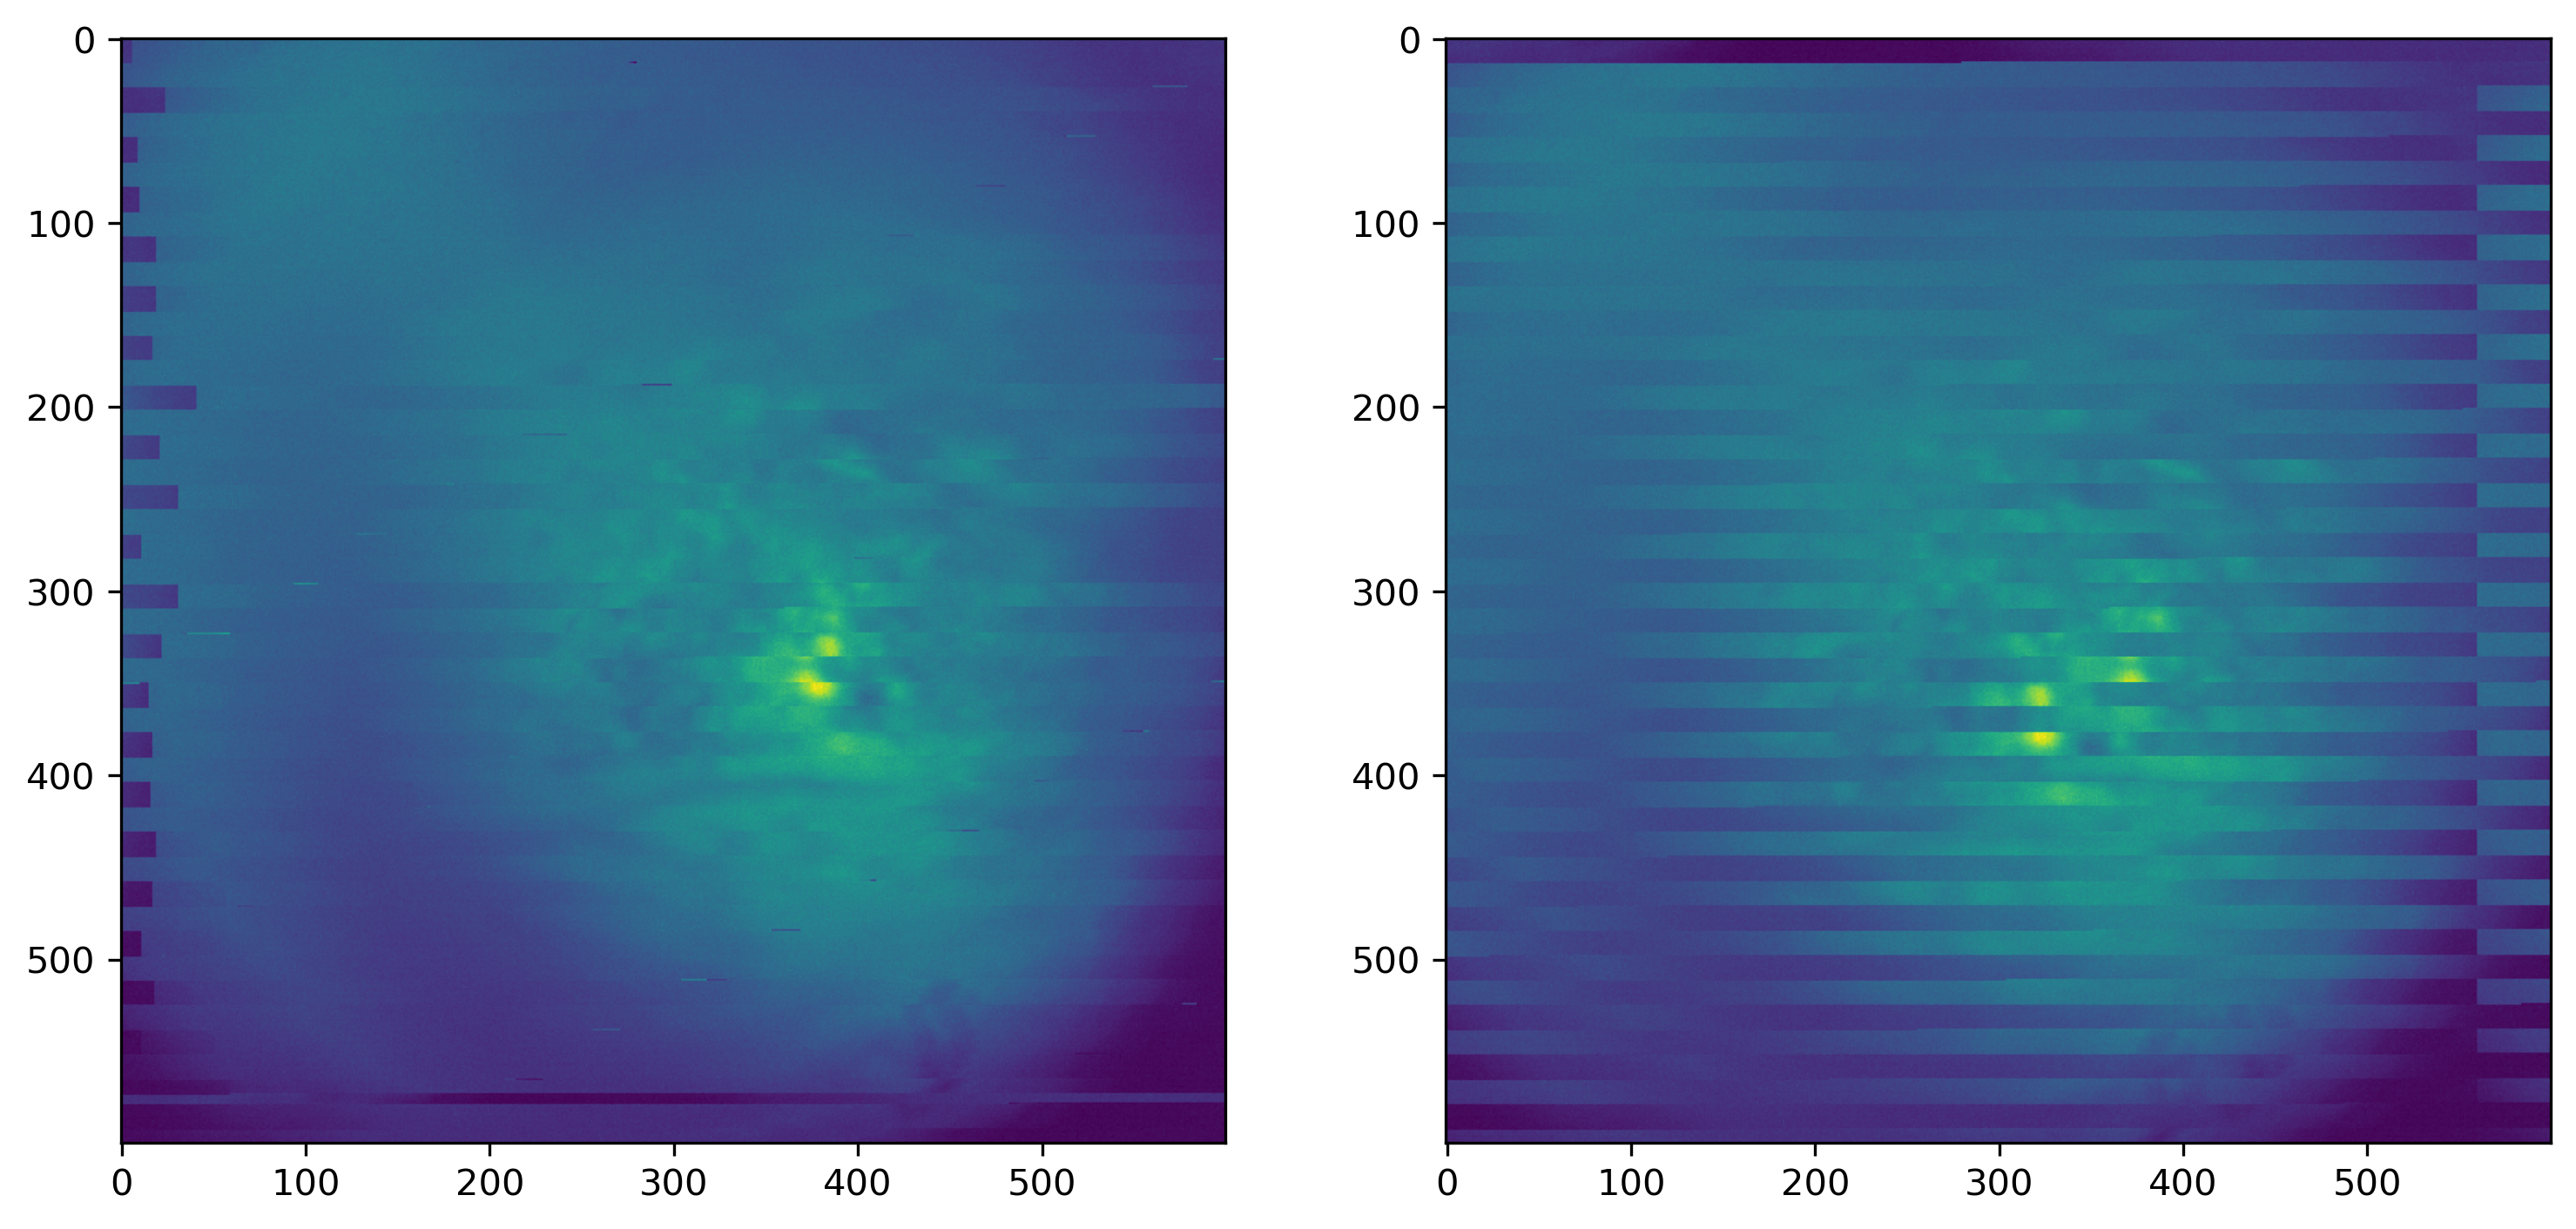

In [257]:
plt.figure(figsize=(12, 6), dpi = 300)

plt.subplot(1, 2, 1)
plt.imshow(new_frame.reshape(frame.shape).astype(frame.dtype))
plt.subplot(1, 2, 2)
plt.imshow(frame)
plt.show()

In [76]:

        
compressionCodec = "GREY"
codec = cv2.VideoWriter_fourcc(*compressionCodec)
    
#reference frame 
ref_frame = varr_ref[bad_frames[0]-1].values

    
# For each video...
for video, bad_frame_numbers in zip(fnames, frame_numbers):
    #print(f'Rewriting {video}')
    cap = cv2.VideoCapture(video)
    rows, cols = int(cap.get(4)), int(cap.get(3))
        
    fname = os.path.split(video)[1]
 

    #writeFile = cv2.VideoWriter(video, codec, 60, (cols,rows), isColor=False)
        
    for frame_number in tqdm(range(int(cap.get(7)))):
        ret, frame = cap.read()
        if ret:
            write_frame = frame[:,:,0]
            
            if frame_number in bad_frame_numbers:
                # Determine buffers
                buffers = determine_buffers(write_frame, ref_frame)
                    
                # Label buffer
                labeled_frame = label_buffer(write_frame, buffers)
                    
                # Fix frame
                #fixed_frame, _ = fix_frame(labeled_frame, ref_frame, buffers)


labeled_frame



100%|██████████| 1000/1000 [00:07<00:00, 136.49it/s]


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [67]:
frame_number

999

# Further corrections

At this point, inspect the new videos and compare them to the ones in the "original" folder. If the new ones look pristine, you're done! Skip the remaining steps and proceed to Minian.

If the new videos still have stripes, you have no choice but to replace those frames with the most recent good frame. Usually these stripes are "nonstationary", as in they sweep across the image rather than being static. I haven't figured out how to correct these, so the workaround is to replace them with the most recent good frame. Proceed ahead. 

In [248]:
%%time
# Reload the whole again movie. Make sure you replaced the files with the repaired ones!! 
varr = load_videos(dpath, **param_load_videos)

loading 1 videos in folder /scratch/09117/xz6783/minian/Satiation/Session Combined/1H6
CPU times: user 104 ms, sys: 12.6 ms, total: 117 ms
Wall time: 247 ms


In [249]:
varr_ref = varr.chunk({"frame": 20, "height": -1, "width": -1})

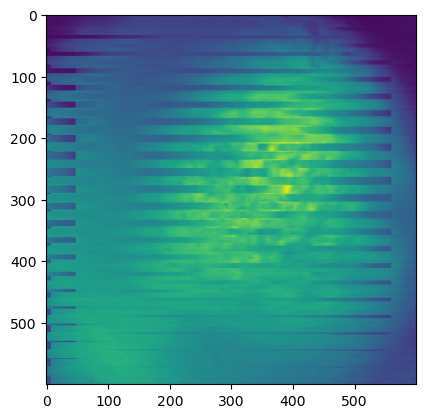

In [250]:
varr_min = varr_ref.min("frame").compute()
plt.imshow(varr_min)

In [ ]:
# varr_ref = sensor_denoise(varr_ref, n=5, y=2)
# min_val = varr_ref.min().compute()
# max_val = varr_ref.max().compute()
# varr_ref = ((varr_ref - min_val) / (max_val - min_val) * 255)
# varr_ref = varr_ref.astype(np.uint8)

## Look for striped frames again

In [ ]:
frames_without_stripes = no_stripes_frames(varr_ref).values
bad_frames = np.asarray(varr_ref[~frames_without_stripes].frame)
bad_frames

In [ ]:
# Inspect frames by eye and optionally, save the frames to a folder.

def plot_bad_frame(bad_frame, save=False, show_plot=False, dpath=dpath):
    x = varr_ref.sel(frame=bad_frame)
    f, Pxx_spec = periodogram(x[:,0], 1)
    peaks = find_peaks(np.sqrt(Pxx_spec)[:int(len(Pxx_spec)/5)], height=20)[0]
    fig, ax = plt.subplots(ncols=2, figsize=(40,10))
    ax[0].imshow(x, cmap='binary_r', aspect='equal', origin='lower')
    ax[1].semilogy(f, np.sqrt(Pxx_spec), c='k')
    ax[1].scatter(f[peaks], np.sqrt(Pxx_spec)[peaks], s=100, c='brown')
    if len(peaks) > 1:
        ax[1].text(x = 0.01, y = 0.1, s='Frame has stripes', color='brown', fontsize=20)
    ax[1].set_ylim([1e-2, 1e3])
    ax[1].margins(x=0.01)
    ax[1].set_xlabel('Frequency [Hz]', fontsize=30)
    ax[1].set_ylabel('Linear spectrum [V RMS]', fontsize=30)
    
    if show_plot:
        fig.show()
    else:
        plt.close(fig)
    
    if save:
        fig.savefig(os.path.join(dpath, 'bad_frames', str(bad_frame) + '.png'))
        
    return f, peaks

In [ ]:
bad_frames_folder = os.path.join(dpath, 'bad_frames')
if not os.path.exists(bad_frames_folder):
    os.mkdir(bad_frames_folder)
for bad_frame in tqdm(bad_frames):
    plot_bad_frame(bad_frame, show_plot=False, save=True)

## Identify chunks where the stripes exist

In [ ]:
def group_consecutives(vals, step=1):
    """Return list of consecutive lists of numbers from vals (number list)."""
    run = []
    result = [run]
    expect = None
    for v in vals:
        if (v == expect) or (expect is None):
            run.append(v)
        else:
            run = [v]
            result.append(run)
        expect = v + step
    return result

In [ ]:
def rewrite_video(fnames, frame_numbers):
    folder = os.path.join(os.path.split(fnames[0])[0], 'failed_to_fix')
    if not os.path.exists(folder):
        os.mkdir(folder)
        print(f'Created {folder}')

    compressionCodec = "FFV1"
    codec = cv2.VideoWriter_fourcc(*compressionCodec)

    # For each video...
    for video, frames in zip(fnames, frame_numbers):
        print(f'Rewriting {video}')
        cap = cv2.VideoCapture(video)
        rows, cols = int(cap.get(4)), int(cap.get(3))
        chunk_number = 0

        fname = os.path.split(video)[1]
        move_fpath = os.path.join(folder, fname)
        
        # Move the original file. 
        if not os.path.exists(move_fpath):
            shutil.move(video, move_fpath)
            print(f'Moved {video} to {move_fpath}')
        else:
            raise FileExistsError('The folder is already storing an original file. Aborting to prevent overwrite.')
        writeFile = cv2.VideoWriter(video, codec, 60, (cols,rows), isColor=False)

        # Group the frame numbers into chunks. Get the frame number that will replace all the bad frames.
        # This is the frame right before the first bad frame in each chunk.
        frame_chunks = group_consecutives(frames)
        frame_chunks = [np.arange(chunk[0], chunk[-1]+2) for chunk in frame_chunks]
        replacement_frame_number = [frames[0]-1 for frames in frame_chunks]

        # For each frame in the video...
        for frame_number in tqdm(range(int(cap.get(7)))):
            ret, frame = cap.read()
            frame = frame[:,:,1]

            if ret:
                # If it's a replacement frame, store it. 
                if frame_number in replacement_frame_number:
                    #print('found replacement')
                    replacement_frame = frame

                    chunk_number = replacement_frame_number.index(frame_number)

                # If it's a bad frame, replace it with the replacement frame. 
                elif frame_number in frame_chunks[chunk_number]:
                    #print('replacing a frame')
                    frame = replacement_frame

                #print('writing')
                writeFile.write(np.uint8(frame))
            else:
                break

        writeFile.release()
        cap.release()
    cv2.destroyAllWindows()

In [ ]:
fnames, frame_numbers = get_filename(bad_frames)
fnames

## write new videos by replacing the bad frames with the last good one
Running the cell below will create another directory "failed_to_fix". It will move the files you recently created above that are still not okay, and it will move those to the "failed_to_fix" folder. Then it will write yet more new videos that will replace the striped frames with the last good one. After this finishes, check the new video files to see if they look okay. If so, you should be good to proceed to Minian. If not, you may have to adjust some parameters for stripe detection and try again. 

In [ ]:
rewrite_video(fnames, frame_numbers)